In [ ]:
!pip install transformers

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk
nltk.download('punkt')
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('stopwords')
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
from numpy import concatenate
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# specify GPU
device = torch.device("cuda")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Load Dataset

In [ ]:
#https://www.kaggle.com/datasets/ziedzen/levantine-arabic-hate-speech-detection-corpus?select=Arabic_Tweets_dataset.csv
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/MyDrive/Arabic_Hate_Speech/arHateDataset.csv')
data.head()

Mounted at /content/drive


,Tweet,Class
0,تعلن #وزارة_الصحة عن وفاة مقيم مصاب بمرض كورون...,0
1,خايفة يجيبوا لقاح الكورونا وما يكفينا ، يقوموا...,0
2,رسمياً.. #الرئاسة_الجزائرية تؤكد إصابة الرئيس ...,0
3,تخيل تجيلك كورونا قبل ما تتزوج تبقي مأساة،\nبع...,0
4,مصير الجزائر والجزائريين معلق بمصير اخواننا وا...,0


In [ ]:
data['label'] = data['Class']
data['text'] = data['Tweet']
data.head()

,Tweet,Class,label,text
0,تعلن #وزارة_الصحة عن وفاة مقيم مصاب بمرض كورون...,0,0,تعلن #وزارة_الصحة عن وفاة مقيم مصاب بمرض كورون...
1,خايفة يجيبوا لقاح الكورونا وما يكفينا ، يقوموا...,0,0,خايفة يجيبوا لقاح الكورونا وما يكفينا ، يقوموا...
2,رسمياً.. #الرئاسة_الجزائرية تؤكد إصابة الرئيس ...,0,0,رسمياً.. #الرئاسة_الجزائرية تؤكد إصابة الرئيس ...
3,تخيل تجيلك كورونا قبل ما تتزوج تبقي مأساة،\nبع...,0,0,تخيل تجيلك كورونا قبل ما تتزوج تبقي مأساة،\nبع...
4,مصير الجزائر والجزائريين معلق بمصير اخواننا وا...,0,0,مصير الجزائر والجزائريين معلق بمصير اخواننا وا...


In [ ]:
data['label'].value_counts(normalize = True)

,proportion
label,
0,0.67543
1,0.32457


label
0    22789
1    10951
Name: count, dtype: int64


<Axes: xlabel='label', ylabel='count'>

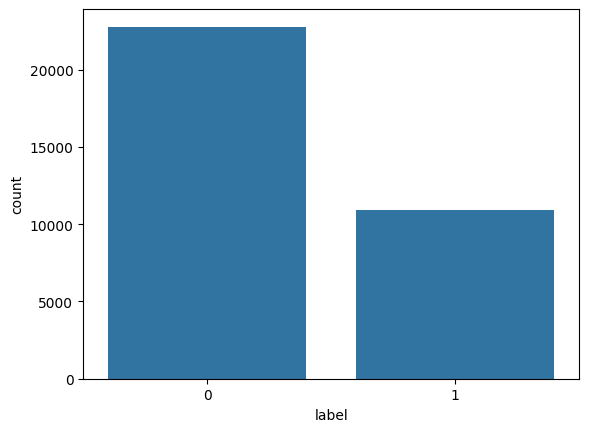

In [ ]:
print(data['label'].value_counts())
sns.countplot(data = data , x='label')

# Data Cleaning

In [ ]:
data= data.dropna()
data['label'] = data['label'].astype(int)
# Remove rows with any nan values

data.head()

,Tweet,Class,label,text
0,تعلن #وزارة_الصحة عن وفاة مقيم مصاب بمرض كورون...,0,0,تعلن #وزارة_الصحة عن وفاة مقيم مصاب بمرض كورون...
1,خايفة يجيبوا لقاح الكورونا وما يكفينا ، يقوموا...,0,0,خايفة يجيبوا لقاح الكورونا وما يكفينا ، يقوموا...
2,رسمياً.. #الرئاسة_الجزائرية تؤكد إصابة الرئيس ...,0,0,رسمياً.. #الرئاسة_الجزائرية تؤكد إصابة الرئيس ...
3,تخيل تجيلك كورونا قبل ما تتزوج تبقي مأساة،\nبع...,0,0,تخيل تجيلك كورونا قبل ما تتزوج تبقي مأساة،\nبع...
4,مصير الجزائر والجزائريين معلق بمصير اخواننا وا...,0,0,مصير الجزائر والجزائريين معلق بمصير اخواننا وا...


In [ ]:
arabic_punctuations = '''`÷« »×؛<>٩٨'٧٦٥٤٣٢١٠_()↗*•&^%][ـ،/:"؟.,'{}⋮≈~¦+|٪!”…“–ـ/[]%=#*+\•~@£·_{}©^®`→°€™›♥←×§″′Â█à…“★”–●â►−¢¬░¶↑±▾	═¦║―¥▓—‹─▒：⊕▼▪†■’▀¨▄♫☆é¯♦¤▲è¸Ã⋅‘∞∙）↓、│（»，♪╩╚³・╦╣╔╗▬❤ïØ¹≤‡₹´'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations

arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)

In [ ]:
import re
def remove_diacritics(df):
    df['text'] = df['text'].apply(lambda x: _remove_diacritics(x))
    return df
def _remove_diacritics(x):
    x = str(x)
    x = re.sub(arabic_diacritics, '', x)
    return x

def normalize_arabic(df):
    df['text'] = df['text'].apply(lambda x: _normalize_arabic(x))
    return df
def _normalize_arabic(x):
    x = str(x)
    # added space around puncts after replace
    x = re.sub("[إأآا]", "ا", x)
    x = re.sub("ى", "ي", x)
    x = re.sub("ؤ", "ء", x)
    x = re.sub("ئ", "ء", x)
    x = re.sub("ة", "ه", x)
    x = re.sub("گ", "ك", x)
    return x

def remove_punctuations(df):
    df['text'] = df['text'].apply(lambda x: _remove_punctuations(x))
    return df
def _remove_punctuations(x):
    x = str(x)
    #translator = str.maketrans(' ', ' ', punctuations_list)
    translator = str.maketrans(punctuations_list, ' '*len(punctuations_list))
    return x.translate(translator)

def remove_repeating_char(df):
    df['text'] = df['text'].apply(lambda x: _remove_repeating_char(x))
    return df
def _remove_repeating_char(x):
    x = str(x)
    return re.sub(r'(.)\1+', r'\1', x)

def remove_english_word_and_numbers(df):
    df['text'] = df['text'].apply(lambda x: _remove_english_word_and_numbers(x))
    return df
def _remove_english_word_and_numbers(x):
    x = str(x)
    return re.sub(r'[a-zA-Z0-9]+', '', x)

def clean_space(df):
    compiled_re = re.compile(r"\s+")
    df['text'] = df["text"].apply(lambda x: _clean_space(x, compiled_re))
    return df
def _clean_space(x, compiled_re):
    return compiled_re.sub(" ", x)

def remove_emojis(text):
    if not isinstance(text, str):
        raise TypeError("Input must be a string")

    # Emoji pattern
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [ ]:
def clean(df):
    df = remove_diacritics(df)
    df = normalize_arabic(df)
    df = remove_punctuations(df)
    df = remove_repeating_char(df)
    df= remove_english_word_and_numbers(df)
    df=clean_space(df)
    df['text']= df['text'].apply(remove_emojis)
    return df

In [ ]:
from multiprocessing import Pool
def df_parallelize_run(df, func, num_cores=2):
    df_split = np.array_split(df, num_cores)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [ ]:
data = df_parallelize_run(data,clean)
data.head()

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


,Tweet,Class,label,text
0,تعلن #وزارة_الصحة عن وفاة مقيم مصاب بمرض كورون...,0,0,تعلن وزاره الصحه عن وفاه مقيم مصاب بمرض كورونا...
1,خايفة يجيبوا لقاح الكورونا وما يكفينا ، يقوموا...,0,0,خايفه يجيبوا لقاح الكورونا وما يكفينا يقوموا ي...
2,رسمياً.. #الرئاسة_الجزائرية تؤكد إصابة الرئيس ...,0,0,رسميا الرءاسه الجزاءريه تءكد اصابه الرءيس تبون...
3,تخيل تجيلك كورونا قبل ما تتزوج تبقي مأساة،\nبع...,0,0,تخيل تجيلك كورونا قبل ما تزوج تبقي ماساه بعد ا...
4,مصير الجزائر والجزائريين معلق بمصير اخواننا وا...,0,0,مصير الجزاءر والجزاءرين معلق بمصير اخوانا واهل...


In [ ]:
# Drop the off_label column from the train_data_cleaned DataFrame
data = data.drop('Tweet', axis=1)
data = data.drop('Class', axis=1)

In [ ]:
data.head()

,label,text
0,0,تعلن وزاره الصحه عن وفاه مقيم مصاب بمرض كورونا...
1,0,خايفه يجيبوا لقاح الكورونا وما يكفينا يقوموا ي...
2,0,رسميا الرءاسه الجزاءريه تءكد اصابه الرءيس تبون...
3,0,تخيل تجيلك كورونا قبل ما تزوج تبقي ماساه بعد ا...
4,0,مصير الجزاءر والجزاءرين معلق بمصير اخوانا واهل...


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from transformers import AutoModel, BertTokenizerFast, AdamW
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import classification_report
import pandas as pd

# Data Splitting
train_text, temp_text, train_labels, temp_labels = train_test_split(data['text'], data['label'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=data['label'])

val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

# BERT Model and Tokenizer
bert = AutoModel.from_pretrained('aubmindlab/bert-base-arabertv02-twitter')
tokenizer = BertTokenizerFast.from_pretrained('aubmindlab/bert-base-arabertv02-twitter')

# Tokenization
def tokenize_sequences(text, labels, max_length):
    tokens = tokenizer.batch_encode_plus(
        text.tolist(),
        max_length=max_length,
        padding='max_length',
        truncation=True
    )
    input_ids = torch.tensor(tokens['input_ids']).to(device)
    attention_mask = torch.tensor(tokens['attention_mask']).to(device)
    labels = torch.tensor(labels.tolist()).to(device)
    return input_ids, attention_mask, labels

# Adjust sequence length based on available memory
max_length = 25 if torch.cuda.is_available() else 64

train_input_ids, train_attention_mask, train_labels = tokenize_sequences(train_text, train_labels, max_length)
val_input_ids, val_attention_mask, val_labels = tokenize_sequences(val_text, val_labels, max_length)
test_input_ids, test_attention_mask, test_labels = tokenize_sequences(test_text, test_labels, max_length)

# Data Loaders
batch_size = 16 if torch.cuda.is_available() else 8  # Reduce batch size if GPU memory is limited

train_data = TensorDataset(train_input_ids, train_attention_mask, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_input_ids, val_attention_mask, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Model Architecture
class BERT_Arch(nn.Module):
    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, 2)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_ids, attention_mask):
        _, cls_hs = self.bert(input_ids, attention_mask=attention_mask, return_dict=False)
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

# Model Initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERT_Arch(bert).to(device)

# Optimizer and Loss Function
optimizer = AdamW(model.parameters(), lr=1e-5)
# Compute class weights
all_labels = np.concatenate([train_labels.cpu().numpy(), val_labels.cpu().numpy(), test_labels.cpu().numpy()])
unique_classes = np.unique(all_labels)
class_weights = torch.tensor(compute_class_weight(class_weight="balanced", classes=unique_classes, y=all_labels), dtype=torch.float)
class_weights = class_weights.to(device)

cross_entropy = nn.NLLLoss(weight=class_weights)

# Training and Evaluation Functions
def train_epoch(model, train_dataloader, optimizer, cross_entropy):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        optimizer.zero_grad()
        preds = model(input_ids, attention_mask)
        loss = cross_entropy(preds, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_dataloader)
    return avg_loss

def evaluate(model, val_dataloader, cross_entropy):
    model.eval()
    total_loss = 0
    preds_list = []
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            preds = model(input_ids, attention_mask)
            loss = cross_entropy(preds, labels)
            total_loss += loss.item()
            preds_list.extend(torch.argmax(preds, axis=1).cpu().numpy())
    avg_loss = total_loss / len(val_dataloader)
    return avg_loss, preds_list

# Training Loop
best_valid_loss = float('inf')
epochs = 3
for epoch in range(epochs):
    train_loss = train_epoch(model, train_dataloader, optimizer, cross_entropy)
    val_loss, val_preds = evaluate(model, val_dataloader, cross_entropy)
    if val_loss < best_valid_loss:
        best_valid_loss = val_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    print(f'\nEpoch {epoch + 1}/{epochs}')
    print(f'Training Loss: {train_loss:.3f} | Validation Loss: {val_loss:.3f}')

# Model Evaluation
model.load_state_dict(torch.load('saved_weights.pt'))
model.eval()
test_input_ids, test_attention_mask, test_labels = test_input_ids.to(device), test_attention_mask.to(device), test_labels.to(device)
with torch.no_grad():
    test_preds = model(test_input_ids, test_attention_mask)
test_preds = torch.argmax(test_preds, axis=1).cpu().numpy()
print(classification_report(test_labels.cpu().numpy(), test_preds))

# Save results to CSV file
test_results = pd.DataFrame({'text': test_text, 'label': test_labels.cpu().numpy(), 'prediction': test_preds})
test_results.to_csv('test_results.csv', index=False)


Some weights of BertModel were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02-twitter and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Epoch 1/3
Training Loss: 0.324 | Validation Loss: 0.243

Epoch 2/3
Training Loss: 0.207 | Validation Loss: 0.300

Epoch 3/3
Training Loss: 0.143 | Validation Loss: 0.381
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      3419
           1       0.84      0.88      0.86      1642

    accuracy                           0.90      5061
   macro avg       0.89      0.90      0.89      5061
weighted avg       0.91      0.90      0.91      5061



In [ ]:
import pandas as pd
from itertools import product
from hyperopt import hp, fmin, tpe, Trials
import matplotlib.pyplot as plt
# Define the new hyperparameter search space
space = {
    "per_gpu_batch_size": hp.choice("per_gpu_batch_size", [16, 32, 64]),
    "weight_decay": hp.uniform("weight_decay", 0, 0.3),
    "learning_rate": hp.uniform("learning_rate", 1e-5, 5e-5),
    "num_epochs": hp.choice("num_epochs", [2, 3, 4, 5])
}

results = []

# Training and Evaluation Functions
# function to train the model
def train(model, train_dataloader, optimizer, cross_entropy):
    model.train()
    total_loss = 0
    total_preds = []

    for step, batch in enumerate(train_dataloader):
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch

        optimizer.zero_grad()
        preds = model(sent_id, mask)
        loss = cross_entropy(preds, labels)
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        preds = preds.detach().cpu().numpy()
        total_preds.append(preds)

    avg_loss = total_loss / len(train_dataloader)
    total_preds = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

# function for evaluating the model
def evaluate(model, val_dataloader, cross_entropy):
    model.eval()
    total_loss = 0
    total_preds = []

    for step, batch in enumerate(val_dataloader):
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch

        with torch.no_grad():
            preds = model(sent_id, mask)
            loss = cross_entropy(preds, labels)
            total_loss += loss.item()

            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)

    avg_loss = total_loss / len(val_dataloader)
    total_preds = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds
# Objective function for hyperparameter optimization
def objective(params):
    batch_size = params["per_gpu_batch_size"]
    lr = params["learning_rate"]
    epochs = params["num_epochs"]
    weight_decay = params["weight_decay"]

    print(f"Training with batch size={batch_size}, learning rate={lr}, num_epochs={epochs}, "
          f"weight_decay={weight_decay}...")

    # Data Loaders
    batch_size = batch_size
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

    # Initialize or update the model, optimizer, and data loaders with the current hyperparameters
    model = BERT_Arch(bert).to(device)
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)


    # Training Loop
    best_valid_loss = float('inf')
    for epoch in range(epochs):
        train_loss = train(model, train_dataloader, optimizer, cross_entropy)
        val_loss, _ = evaluate(model, val_dataloader, cross_entropy)
        if val_loss < best_valid_loss:
            best_valid_loss = val_loss

    # Record hyperparameters and corresponding evaluation metrics in results
    results.append({
        "per_gpu_batch_size": batch_size,
        "learning_rate": lr,
        "num_epochs": epochs,
        "weight_decay": weight_decay,
        "validation_loss": best_valid_loss
    })

    # Return the validation loss to minimize
    return best_valid_loss

# Run hyperparameter optimization
best = fmin(
    fn=objective,            # Objective function to minimize
    space=space,             # Search space
    algo=tpe.suggest,        # Optimization algorithm (Tree of Parzen Estimators)
    max_evals=10,            # Maximum number of evaluations
    trials=Trials()          # Object to store optimization results
)

# Visualize hyperparameters vs. validation loss
results_df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))

# Plot per_gpu_batch_size vs. validation loss
plt.subplot(2, 2, 1)
plt.scatter(results_df['per_gpu_batch_size'], results_df['validation_loss'], color='blue')
plt.xlabel('per_gpu_batch_size')
plt.ylabel('Validation Loss')
plt.title('per_gpu_batch_size vs. Validation Loss')

# Plot weight_decay vs. validation loss
plt.subplot(2, 2, 2)
plt.scatter(results_df['weight_decay'], results_df['validation_loss'], color='red')
plt.xlabel('weight_decay')
plt.ylabel('Validation Loss')
plt.title('weight_decay vs. Validation Loss')

# Plot learning_rate vs. validation loss
plt.subplot(2, 2, 3)
plt.scatter(results_df['learning_rate'], results_df['validation_loss'], color='green')
plt.xlabel('learning_rate')
plt.ylabel('Validation Loss')
plt.title('learning_rate vs. Validation Loss')

# Plot num_epochs vs. validation loss
plt.subplot(2, 2, 4)
plt.scatter(results_df['num_epochs'], results_df['validation_loss'], color='orange')
plt.xlabel('num_epochs')
plt.ylabel('Validation Loss')
plt.title('num_epochs vs. Validation Loss')

plt.tight_layout()
plt.show()
# Find the best hyperparameters based on validation loss
best_hyperparams = min(results, key=lambda x: x['validation_loss'])
print("Best Hyperparameters:", best_hyperparams)

# Save results to CSV file
results_df = pd.DataFrame(results)
results_df.to_csv('hyperparameter_results.csv', index=False)


# Plot hyperparameters vs. validation loss
for param in space.keys():
    plt.figure()
    plt.plot(results_df[param], results_df['validation_loss'], marker='o')
    plt.title(f'{param} vs. Validation Loss')
    plt.xlabel(param)
    plt.ylabel('Validation Loss')
    plt.grid(True)
    plt.savefig(f'{param}_vs_validation_loss.png')
    plt.show()